In [6]:
#!/usr/bin/env python3
import torch, math
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
#from utils import get_extracted_xvectors, get_mean_scores
from sklearn.model_selection import KFold, LeaveOneOut, cross_validate
import argparse
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model


class LinearRegression:
    def fit(self, X, y, method, learning_rate=0.01, iterations=500, batch_size=32):
        X, y = torch.from_numpy(X), torch.from_numpy(y)
        X = torch.cat([(X), torch.ones_like(y)], dim=1)
        rows, cols = X.size()
        if method == 'solve':
            if rows >= cols == torch.matrix_rank(X):
                self.weights = torch.matmul(
                    torch.matmul(
                        torch.inverse(
                            torch.matmul(
                                torch.transpose(X, 0, 1),
                                X)),
                        torch.transpose(X, 0, 1)),
                    y)
            else:
                print('X has not full column rank. method=\'solve\' cannot be used.')
        elif method == 'sgd':
            self.weights = torch.normal(mean=0, std=1/cols, size=(cols, 1), dtype=torch.float64)
            for i in range(iterations):
                Xy = torch.cat([X, y], dim=1)
                Xy = Xy[torch.randperm(Xy.size()[0])]
                X, y = torch.split(Xy, [Xy.size()[1]-1, 1], dim=1)
                for j in range(int(math.ceil(rows/batch_size))):
                    start, end = batch_size*j, min(batch_size*(j+1), rows)
                    Xb = torch.index_select(X, 0, torch.arange(start, end))
                    yb = torch.index_select(y, 0, torch.arange(start, end))
                    
                    self.weights.requires_grad_(True)
                    diff = torch.matmul(Xb, self.weights) - yb
                    loss = torch.matmul(torch.transpose(diff, 0, 1), diff)
                    loss.backward()
                    
                    self.weights = (self.weights - learning_rate*self.weights.grad).detach()
        else:
            print(f'Unknown method: \'{method}\'')
        
        return self
    
    def predict(self, X):
        X = torch.from_numpy(X)
        if not hasattr(self, 'weights'):
            print('Cannot predict. You should call the .fit() method first.')
            return
        
        X = torch.cat([X, torch.ones((X.size()[0], 1))], dim=1)
        
        if X.size()[1] != self.weights.size()[0]:
            print(f'Shapes do not match. {X.size()[1]} != {self.weights.size()[0]}')
            return
        
        return torch.matmul(X, self.weights)
    
    def rmse(self, X, y):
        y = torch.from_numpy(y)
        y_hat = self.predict(X)
        
        if y_hat is None:
            return
        
        return torch.sqrt(torch.mean(torch.square(y_hat - y)))




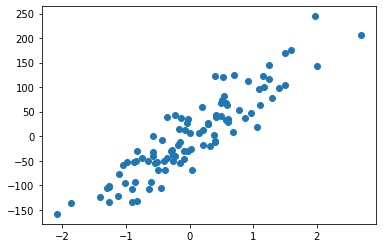

In [22]:
X, y = make_regression(n_features=1, n_informative=1,
                       bias=1, noise=35)

X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y.reshape((-1, 1)))

plt.scatter(X, y)
y = y.reshape((-1, 1))

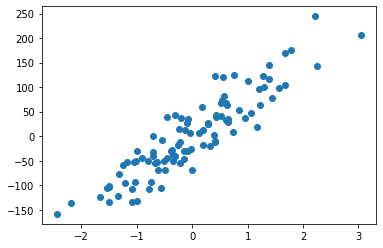

In [24]:
plt.scatter(X_scaled, y)

tensor(34.3364, dtype=torch.float64)

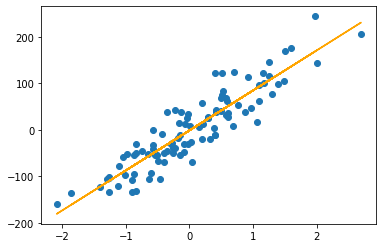

In [36]:
lr_solve = LinearRegression().fit(X, y, method='solve')
plt.scatter(X, y)
plt.plot(X, lr_solve.predict(X), color='orange')
lr_solve.rmse(X, y)

tensor(34.4790, dtype=torch.float64)

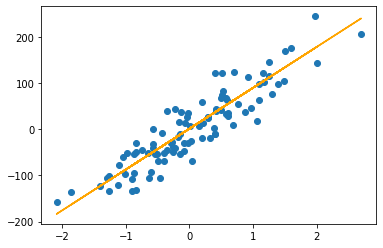

In [37]:
lr_sgd = LinearRegression().fit(X, y, method='sgd')
plt.scatter(X, y)
plt.plot(X, lr_sgd.predict(X), color='orange')
lr_sgd.rmse(X, y)

In [47]:
lr_sklearn = sklearn.linear_model.LinearRegression().fit(X, y)
# plt.scatter(X, y)
# plt.plot(X, lr_sklearn.predict(X), color='orange')

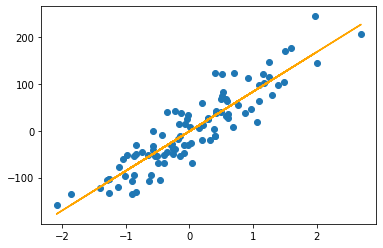

In [48]:
plt.scatter(X, y)
plt.plot(X, lr_sklearn.predict(X), color='orange')

In [49]:
all_loss=[52.805686950683594, 44.469261169433594, 38.33108139038086, 33.81060791015625, 30.48073387145996, 28.027151107788086, 26.218597412109375, 24.884855270385742, 23.900615692138672, 23.17367935180664, 22.636167526245117, 22.23809242248535, 21.942689895629883, 21.722862243652344, 21.55870246887207, 21.435503005981445, 21.342479705810547, 21.27168083190918, 21.21722412109375, 21.174808502197266, 21.141273498535156, 21.114267349243164, 21.092060089111328, 21.073402404785156, 21.057353973388672, 21.043237686157227, 21.030532836914062, 21.01886558532715, 21.00798225402832, 20.99765968322754, 20.987762451171875, 20.978174209594727, 20.96880531311035, 20.959604263305664, 20.950551986694336, 20.941577911376953, 20.932687759399414, 20.923851013183594, 20.915048599243164, 20.906280517578125, 20.897539138793945, 20.88881492614746, 20.88010597229004, 20.871416091918945, 20.862730026245117, 20.854047775268555, 20.84537696838379, 20.836715698242188, 20.828073501586914, 20.819421768188477, 20.81077766418457, 20.802148818969727, 20.793521881103516, 20.784896850585938, 20.776283264160156, 20.767662048339844, 20.759048461914062, 20.750459671020508, 20.741863250732422, 20.7332763671875, 20.724685668945312, 20.716108322143555, 20.707523345947266, 20.6989688873291, 20.69039535522461, 20.681833267211914, 20.67327880859375, 20.664735794067383, 20.656187057495117, 20.647653579711914, 20.639114379882812, 20.63059425354004, 20.6220703125, 20.61354637145996, 20.605037689208984, 20.596527099609375, 20.58803367614746, 20.579532623291016, 20.571029663085938, 20.562541961669922, 20.554061889648438, 20.54558753967285, 20.537113189697266, 20.528644561767578, 20.520185470581055, 20.511728286743164, 20.5032958984375, 20.494829177856445, 20.48638916015625, 20.477954864501953, 20.46952247619629, 20.46108627319336, 20.45268440246582, 20.444263458251953, 20.435850143432617, 20.427440643310547, 20.419042587280273, 20.4106502532959, 20.402250289916992, 20.39385414123535]

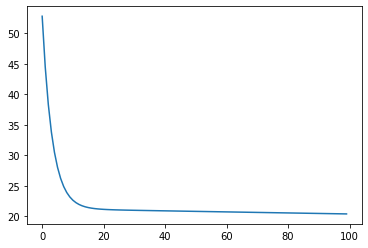

In [50]:
plt.plot(all_loss)